<a href="https://colab.research.google.com/github/Jayathilaga/Data-Augmentation/blob/main/data_aug_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing the [Kaggle API](https://github.com/Kaggle/kaggle-api) in Colab

In [ ]:
!pip install kaggle
!pip install nlpaug

# Authenticating with Kaggle using kaggle.json

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below to upload kaggle.json to your Colab runtime.

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


# Downloading required data

In [ ]:
!kaggle competitions download -c nlp-getting-started
!kaggle datasets download -d rtatman/glove-global-vectors-for-word-representation

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
glove-global-vectors-for-word-representation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip /content/glove-global-vectors-for-word-representation.zip

Archive:  /content/glove-global-vectors-for-word-representation.zip
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Importing packages

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
nltk.download('all')
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re

from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import os


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

In [ ]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

from nlpaug.util import Action

## Loading the data and getting basic idea 

In [ ]:
tweet= pd.read_csv('/content/train.csv')
test=pd.read_csv('/content/test.csv')
tweet.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [ ]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


In [ ]:
tweet=tweet.drop(['keyword','location'],axis=1)

## Class distribution

Before we begin with anything else,let's check the class distribution.There are only two classes 0 and 1.

Text(0, 0.5, 'samples')

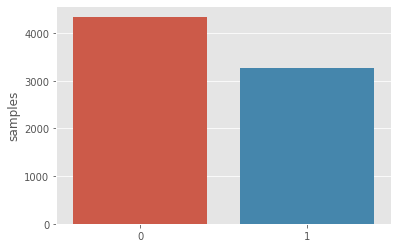

In [ ]:
x=tweet.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

ohh,as expected ! There is a class distribution.There are more tweets with class 0 ( No disaster) than class 1 ( disaster tweets)

# Data Augmentation

In [ ]:
# model_type: word2vec, glove or fasttext
aug_w2v = naw.WordEmbsAug(
#     model_type='word2vec', model_path='../input/nlpword2vecembeddingspretrained/GoogleNews-vectors-negative300.bin',
    model_type='glove', model_path='/content/glove.6B.100d.txt',
    action="substitute")



In [ ]:
text = tweet.iloc[0]['text']
text

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [ ]:
aug_w2v.aug_p=0.2
print("Augmented Text:")
for ii in range(5):
    augmented_text = aug_w2v.augment(text)
    print(augmented_text)

Augmented Text:
Our Deeds already the Reason what this # earthquake May ALLAH Forgive us all
Our Deeds having up Reason of this # earthquake May ALLAH Forgive us all
Our Deeds are the Reason of present # quakes May ALLAH Forgive us all
Our Deeds many the Reason of this # temblor May ALLAH Forgive us all
Our Deeds either been Reason of this # earthquake May ALLAH Forgive us all


In [ ]:
train,valid=train_test_split(tweet,test_size=0.15)
print('Shape of train',train.shape)
print("Shape of Validation ",valid.shape)

Shape of train (6471, 3)
Shape of Validation  (1142, 3)


In [ ]:
from sklearn.utils import shuffle

def augment_text(df,samples=300,pr=0.2):
    aug_w2v.aug_p=pr
    new_text=[]
    
    ##dropping samples from validation
    df_n=df[df.target==1].reset_index(drop=True)

    ## data augmentation loop
    for i in tqdm(np.random.randint(0,len(df_n),samples)):
        
            text = df_n.iloc[i]['text']
            augmented_text = aug_w2v.augment(text)
            new_text.append(augmented_text)
    
    
    ## dataframe
    new=pd.DataFrame({'text':new_text,'target':1})
    df=shuffle(df.append(new).reset_index(drop=True))
    return df
    
    
    
    
    
    
    

In [ ]:
train = augment_text(train,samples=400)   ## change samples to 0 for no augmentation
tweet = train.append(valid).reset_index(drop=True)


100%|██████████| 400/400 [01:12<00:00,  5.55it/s]


In [ ]:
df=pd.concat([tweet,test])

In [ ]:
df.shape

(11276, 5)

## GloVe for Vectorization

Here we will use GloVe pretrained corpus model to represent our words.It is available in 3 varieties :50D ,100D and 200 Dimentional.We will try 100 D here.
This pipeline is described in [this](https://neptune.ai/blog/document-classification-small-datasets) article.

In [ ]:

def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus
        
        

In [ ]:
corpus=create_corpus(df)

100%|██████████| 11276/11276 [00:02<00:00, 4450.82it/s]


In [ ]:
embedding_dict={}
with open('/content/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [ ]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [ ]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 19034


In [ ]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec
            

100%|██████████| 19034/19034 [00:00<00:00, 492588.94it/s]


## Baseline Model

In [ ]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])



In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           1903500   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,984,001
Trainable params: 80,501
Non-trainable params: 1,903,500
_________________________________________________________________


In [ ]:
train_df=tweet_pad[:tweet.shape[0]]
test_df=tweet_pad[tweet.shape[0]:]

# Train the model

In [ ]:
X_train,y_train = train_df[:train.shape[0]],tweet['target'][:train.shape[0]]

X_test,y_test= train_df[train.shape[0]:],tweet['target'][train.shape[0]:]


In [ ]:
history=model.fit(X_train,y_train,batch_size=4,epochs=10,validation_data=(X_test,y_test),verbose=2)

Train on 6871 samples, validate on 1142 samples
Epoch 1/10
 - 47s - loss: 0.6926 - accuracy: 0.5344 - val_loss: 0.6902 - val_accuracy: 0.5849
Epoch 2/10
 - 45s - loss: 0.6330 - accuracy: 0.6589 - val_loss: 0.5211 - val_accuracy: 0.7680
Epoch 3/10
 - 46s - loss: 0.5710 - accuracy: 0.7289 - val_loss: 0.5090 - val_accuracy: 0.7758
Epoch 4/10
 - 46s - loss: 0.5551 - accuracy: 0.7379 - val_loss: 0.5036 - val_accuracy: 0.7732
Epoch 5/10
 - 45s - loss: 0.5554 - accuracy: 0.7404 - val_loss: 0.4998 - val_accuracy: 0.7767
Epoch 6/10
 - 46s - loss: 0.5470 - accuracy: 0.7452 - val_loss: 0.4986 - val_accuracy: 0.7793
Epoch 7/10
 - 47s - loss: 0.5488 - accuracy: 0.7457 - val_loss: 0.4925 - val_accuracy: 0.7820
Epoch 8/10
 - 46s - loss: 0.5334 - accuracy: 0.7568 - val_loss: 0.4892 - val_accuracy: 0.7855
Epoch 9/10
 - 45s - loss: 0.5344 - accuracy: 0.7559 - val_loss: 0.4948 - val_accuracy: 0.7837
Epoch 10/10
 - 46s - loss: 0.5328 - accuracy: 0.7519 - val_loss: 0.4888 - val_accuracy: 0.7881


# Evaluation

In [ ]:
y_pre=model.predict(X_test)
y_pre=np.round(y_pre).astype(int).reshape(1142)


In [ ]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_pre,y_test))

0.7824407958672192
